# Fedbiomed Researcher

Use for developing (autoreloads changes made across packages)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-01-03 16:12:14,505 fedbiomed INFO - Component environment:
2022-01-03 16:12:14,510 fedbiomed INFO - - type = ComponentType.RESEARCHER
2022-01-03 16:12:15,488 fedbiomed INFO - Messaging researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x107dc6760>
2022-01-03 16:12:15,582 fedbiomed INFO - Listing available datasets in all nodes... 
2022-01-03 16:12:15,608 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / DEBUG - Message received: {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'command': 'list'}
2022-01-03 16:12:15,627 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / DEBUG - Message received: {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'command': 'list'}
2022-01-03 16:12:15,633 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / DEBUG - Message received: {'researcher_id': 'res

{'node_15981cb3-39ef-4c54-9e72-2432d023491f': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [14735, 3, 64, 64]}],
 'node_6db91b12-7507-4dd4-b3ea-788da19cc6ed': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [14738, 3, 64, 64]}],
 'node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [14736, 3, 64, 64]}]}

## Setting the client up
It is necessary to previously configure a node:
1. `./scripts/fedbiomed_run node add`
  * Select option 3 (images) to add MedNIST to the client
  * Confirm default tags by hitting "y" and ENTER
  * Pick the folder where MedNIST is contained
  * Data must have been added (if you get a warning saying that data must be unique is because it's been already added)
  
2. Check that your data has been added by executing `./scripts/fedbiomed_run node list`
3. Run the node using `./scripts/fedbiomed_run node run`. Wait until you get `Connected with result code 0`. it means you are online.

## Create an experiment to train a model on the data found

Declare a torch.nn MyTrainingPlan class to send for training on the node

In [3]:
from fedbiomed.researcher.environ import environ
import tempfile
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+'/')
model_file = tmp_dir_model.name + '/class_export_mednist.py'

In [4]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

Note : write **only** the code to export in the following cell

In [5]:
%%writefile "$model_file"

import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.torchnn import TorchTrainingPlan
from fedbiomed.common.logger import logger
from torchvision import datasets, transforms
from typing import Union, List

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

# Here we define the model to be used. 
class MyMonaiTrainingPlan(TorchTrainingPlan):
    def __init__(self):
        super(MyMonaiTrainingPlan, self).__init__()
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import os",
                "from fedbiomed.common.logger import logger",
                "from torch.nn import MSELoss",
                "from typing import Union, List",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.config import print_config, USE_COMPILED",
                "from monai.networks.nets import GlobalNet",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",]
        self.add_dependency(deps)
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)#.to(self.device)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border").to(self.device)
        else:
            self.warp_layer = Warp("bilinear", "border").to(self.device)
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-5)
        
    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        #train_kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2}
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        
        return train_loader

    # to be modified?
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    def training_routine(self,
                         epochs: int = 2,
                         log_interval: int = 10,
                         lr: Union[int, float] = 1e-3,
                         batch_size: int = 48,
                         batch_maxnum: int = 0,
                         dry_run: bool = False,
                         monitor=None):
        
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.model.to(self.device)
        
        training_data = self.training_data(batch_size=batch_size)

        for epoch in range(1, epochs + 1):
            self.model.train()
            for batch_idx, batch_data in enumerate(training_data):
                self.optimizer.zero_grad()
                moving = batch_data["moving_hand"].to(self.device)
                fixed = batch_data["fixed_hand"].to(self.device)
                res = self.training_step(moving, fixed)
                res.backward()
                #loss.backward()
                self.optimizer.step()

                # do not take into account more than batch_maxnum
                # batches from the dataset
                if (batch_maxnum > 0) and (batch_idx >= batch_maxnum):
                    #print('Reached {} batches for this epoch, ignore remaining data'.format(batch_maxnum))
                    logger.debug('Reached {} batches for this epoch, ignore remaining data'.format(batch_maxnum))
                    break

                if batch_idx % log_interval == 0:
                    logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch,
                        batch_idx * len(moving),
                        len(training_data.dataset),
                        100 * batch_idx / len(training_data),
                        res.item()))

                    # Send scalar values via general/feedback topic
                    if monitor is not None:
                        monitor.add_scalar('Loss', res.item(), batch_idx, epoch)

                    if dry_run:
                        return

Writing /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/tmpn59wqxt1/class_export_mednist.py


This group of arguments correspond respectively:
* `model_args`: a dictionary with the arguments related to the modelwhich will be passed to the model class on the client side. In this case, no model argument is required.
* `training_args`: a dictionary containing the arguments for the training routine (e.g. batch size, learning rate, epochs, etc.). This will be passed to the routine on the client side.

**NOTE:** typos and/or lack of positional (required) arguments will raise error. 🤓

In [6]:
model_args = {}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 5, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

Define an experiment
- search nodes serving data for these `tags`, optionally filter on a list of client ID with `clients`
- run a round of local training on nodes with model defined in `model_path` + federation with `aggregator`
- run for `rounds` rounds, applying the `client_selection_strategy` between the rounds

In [7]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['mednist']
rounds = 5

exp = Experiment(tags=tags,
                 #clients=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='MyMonaiTrainingPlan',
                 training_args=training_args,
                 rounds=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-01-03 16:12:53,617 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
2022-01-03 16:12:53,633 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / DEBUG - Message received: {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'tags': ['mednist'], 'command': 'search'}
2022-01-03 16:12:53,636 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / DEBUG - Message received: {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'tags': ['mednist'], 'command': 'search'}
2022-01-03 16:12:53,646 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / DEBUG - Message received: {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'tags': ['mednist'], 'command': 'search'}
2022-01-03 16:13:03,638 fedbiomed INFO - Node selected for training -> node_6db91b12-7507-4dd4-b3ea-788da19cc6ed
2022-01-03 16:13:03,639 fedbiomed INFO - Node selected for training -> node_d1557b63-00bd-

Let's start the experiment.

By default, this function doesn't stop until all the `rounds` are done for all the clients

In [8]:
exp.run()

2022-01-03 16:13:10,165 fedbiomed INFO - Sampled nodes in round 0 ['node_6db91b12-7507-4dd4-b3ea-788da19cc6ed', 'node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6', 'node_15981cb3-39ef-4c54-9e72-2432d023491f']
2022-01-03 16:13:10,166 fedbiomed INFO - Send message to node node_6db91b12-7507-4dd4-b3ea-788da19cc6ed - {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'job_id': '78dd1c75-4451-477e-9cde-e27c5ea339d5', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}, 'model_args': {}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/03/my_model_a614f02a-6070-48d2-97c7-d6e7f003e314.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/03/my_model_c212228a-c594-4e78-ba69-d72fde7ac27f.pt', 'model_class': 'MyMonaiTrainingPlan', 'training_data': {'node_6db91b12-7507-4dd4-b3ea-788da19cc6ed': ['dataset_3f2099bd-78c9-4cc1-a6e7-fe2fd3153fa1']}}
2022-01-03 16:13:10,168 fedbiomed DEBUG - researcher_2f6

2022-01-03 16:13:11,120 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_1
2022-01-03 16:13:17,343 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.100556
2022-01-03 16:13:17,423 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.099543
2022-01-03 16:13:18,043 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.074604
2022-01-03 16:13:25,085 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.078838
2022-01-03 16:13:25,140 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.080006
2022-01-03 16:13:25,693 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch:

2022-01-03 16:15:31,442 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.054492
2022-01-03 16:15:31,782 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.049994
2022-01-03 16:15:38,932 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.040835
2022-01-03 16:15:38,963 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.041900
2022-01-03 16:15:39,450 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.051350
2022-01-03 16:15:46,452 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.039286
2022-01-03 16:15:46,561 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Trai

2022-01-03 16:17:40,851 fedbiomed INFO - Downloading model params after training on node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 - from http://localhost:8844/media/uploads/2022/01/03/node_params_e96e79c8-5106-4078-82fc-d48e758a003f.pt
2022-01-03 16:17:41,026 fedbiomed INFO - Nodes that successfully reply in round 0 ['node_6db91b12-7507-4dd4-b3ea-788da19cc6ed', 'node_15981cb3-39ef-4c54-9e72-2432d023491f', 'node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6']
2022-01-03 16:17:41,741 fedbiomed INFO - Sampled nodes in round 1 ['node_6db91b12-7507-4dd4-b3ea-788da19cc6ed', 'node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6', 'node_15981cb3-39ef-4c54-9e72-2432d023491f']
2022-01-03 16:17:41,742 fedbiomed INFO - Send message to node node_6db91b12-7507-4dd4-b3ea-788da19cc6ed - {'researcher_id': 'researcher_2f6f9985-2136-4ced-b2b9-ba6cb4a5ecfc', 'job_id': '78dd1c75-4451-477e-9cde-e27c5ea339d5', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}, 'model_args': {}, 'co

2022-01-03 16:17:43,042 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_3
2022-01-03 16:17:43,832 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x156865bb0>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:17:43,834 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_2
2022-01-03 16:17:53,067 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.036620
2022-01-03 16:17:53,121 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.046321
2022-01-03 16:17:53,305 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.0

2022-01-03 16:20:16,824 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.052367
2022-01-03 16:20:16,837 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.053587
2022-01-03 16:20:28,343 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.046928
2022-01-03 16:20:28,401 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.038720
2022-01-03 16:20:28,685 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.048434
2022-01-03 16:20:38,139 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.039153
2022-01-03 16:20:38,246 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Trai

2022-01-03 16:22:57,044 fedbiomed INFO - Downloading model params after training on node_15981cb3-39ef-4c54-9e72-2432d023491f - from http://localhost:8844/media/uploads/2022/01/03/node_params_2ed5b5e3-f379-4f8a-948c-3dd66a0770ad.pt
2022-01-03 16:22:57,351 fedbiomed INFO - Downloading model params after training on node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 - from http://localhost:8844/media/uploads/2022/01/03/node_params_7872deb7-a55e-454f-8392-74c0701ae7d9.pt
2022-01-03 16:22:57,533 fedbiomed INFO - Downloading model params after training on node_6db91b12-7507-4dd4-b3ea-788da19cc6ed - from http://localhost:8844/media/uploads/2022/01/03/node_params_ac0f1d78-bac6-4324-bc6b-199cbcb0ca6f.pt
2022-01-03 16:22:57,761 fedbiomed INFO - Nodes that successfully reply in round 1 ['node_15981cb3-39ef-4c54-9e72-2432d023491f', 'node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6', 'node_6db91b12-7507-4dd4-b3ea-788da19cc6ed']
2022-01-03 16:22:58,206 fedbiomed INFO - Sampled nodes in round 2 ['node_6db91b12-7507

2022-01-03 16:22:58,956 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x156840f70>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:22:58,958 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x14efa6070>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:22:58,959 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_3
2022-01-03 16:22:58,961 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_2
2022-01-03 16:22:59,095 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor obj

2022-01-03 16:25:07,441 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.039803
2022-01-03 16:25:15,637 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.043633
2022-01-03 16:25:15,700 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.040154
2022-01-03 16:25:16,443 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.032840
2022-01-03 16:25:25,317 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.036840
2022-01-03 16:25:25,442 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.046576
2022-01-03 16:25:25,858 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Trai

2022-01-03 16:27:32,839 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.040667
2022-01-03 16:27:32,855 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.039362
2022-01-03 16:27:33,681 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - results uploaded successfully 
2022-01-03 16:27:34,579 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - results uploaded successfully 
2022-01-03 16:27:34,694 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - results uploaded successfully 
2022-01-03 16:27:43,537 fedbiomed INFO - Downloading model params after training on node_6db91b12-7507-4dd4-b3ea-788da19cc6ed - from http://localhost:8844/media/uploads/2022/01/03/node_params_98461850-e4d6-4d22-ac14-cbc5773f1ddf.pt
2022-01-03 16:27:43,673 fedbiomed INFO - Downloading model params after

2022-01-03 16:27:44,712 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x14ef9c190>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:27:44,717 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_3
2022-01-03 16:27:44,766 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x14af3c3a0>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:27:44,768 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_1
2022-01-03 16:27:44,817 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor obj

2022-01-03 16:29:05,663 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.035381
2022-01-03 16:29:10,962 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.034175
2022-01-03 16:29:11,019 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.034482
2022-01-03 16:29:11,178 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.030148
2022-01-03 16:29:16,616 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.035400
2022-01-03 16:29:16,651 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.029682
2022-01-03 16:29:16,848 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Trai

2022-01-03 16:30:51,557 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.045610
2022-01-03 16:30:51,919 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.035318
2022-01-03 16:30:52,992 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - results uploaded successfully 
2022-01-03 16:30:53,394 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - results uploaded successfully 
2022-01-03 16:30:53,552 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - results uploaded successfully 
2022-01-03 16:30:59,508 fedbiomed INFO - Downloading model params after training on node_6db91b12-7507-4dd4-b3ea-788da19cc6ed - from http://localhost:8844/media/uploads/2022/01/03/node_params_764b9e54-ed62-4c92-99a5-e0584fe26372.pt
2022-01-03 16:30:59,636 fedbiomed INFO - Downloading model params after

2022-01-03 16:31:00,709 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x149020b20>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:31:00,714 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_1
2022-01-03 16:31:00,771 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1586658b0>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 5, 'dry_run': False, 'batch_maxnum': 250}
2022-01-03 16:31:00,773 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / DEBUG - Dataset_path/Users/balelli/Downloads/MedNIST_2
2022-01-03 16:31:00,833 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor obj

2022-01-03 16:32:24,475 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.028889
2022-01-03 16:32:30,072 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.029492
2022-01-03 16:32:30,139 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.026799
2022-01-03 16:32:30,252 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 3 [320/1000 (32%)]	Loss: 0.025550
2022-01-03 16:32:35,701 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.026243
2022-01-03 16:32:35,729 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 3 [480/1000 (48%)]	Loss: 0.041484
2022-01-03 16:32:35,924 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Trai

2022-01-03 16:34:04,548 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.028993
2022-01-03 16:34:05,092 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - Train Epoch: 5 [960/1000 (95%)]	Loss: 0.026729
2022-01-03 16:34:06,082 fedbiomed INFO - log from: node_15981cb3-39ef-4c54-9e72-2432d023491f / INFO - results uploaded successfully 
2022-01-03 16:34:06,316 fedbiomed INFO - log from: node_6db91b12-7507-4dd4-b3ea-788da19cc6ed / INFO - results uploaded successfully 
2022-01-03 16:34:06,502 fedbiomed INFO - log from: node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 / INFO - results uploaded successfully 
2022-01-03 16:34:15,481 fedbiomed INFO - Downloading model params after training on node_15981cb3-39ef-4c54-9e72-2432d023491f - from http://localhost:8844/media/uploads/2022/01/03/node_params_91d2283d-aab8-4179-b7ae-258b5436cc06.pt
2022-01-03 16:34:15,614 fedbiomed INFO - Downloading model params after

Local training results for each round and each node are available in `exp.training_replies` (index 0 to (`rounds` - 1) ).

For example you can view the training results for the last round below.

Different timings (in seconds) are reported for each dataset of a node participating in a round :
- `rtime_training` real time (clock time) spent in the training function on the node
- `ptime_training` process time (user and system CPU) spent in the training function on the node
- `rtime_total` real time (clock time) spent in the researcher between sending the request and handling the response, at the `Job()` layer

In [9]:
print("\nList the training rounds : ", exp.training_replies.keys())

print("\nList the clients for the last training round and their timings : ")
round_data = exp.training_replies[rounds - 1].data
for c in range(len(round_data)):
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = round_data[c]['node_id'],
        rtraining = round_data[c]['timing']['rtime_training'],
        ptraining = round_data[c]['timing']['ptime_training'],
        rtotal = round_data[c]['timing']['rtime_total']))
print('\n')
    
exp.training_replies[rounds - 1].dataframe


List the training rounds :  dict_keys([0, 1, 2, 3, 4])

List the clients for the last training round and their timings : 
	- node_15981cb3-39ef-4c54-9e72-2432d023491f :    
		rtime_training=184.58 seconds    
		ptime_training=195.67 seconds    
		rtime_total=195.16 seconds
	- node_6db91b12-7507-4dd4-b3ea-788da19cc6ed :    
		rtime_training=184.67 seconds    
		ptime_training=195.75 seconds    
		rtime_total=195.31 seconds
	- node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6 :    
		rtime_training=185.35 seconds    
		ptime_training=196.22 seconds    
		rtime_total=195.42 seconds




,success,msg,dataset_id,node_id,params_path,params,timing
0,True,,dataset_6cc5939f-c8cd-4da2-aeef-71aea555bbec,node_15981cb3-39ef-4c54-9e72-2432d023491f,/Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed...,{'model.encode_convs.0.0.conv.weight': [[tenso...,"{'rtime_training': 184.57955659699655, 'ptime_..."
1,True,,dataset_3f2099bd-78c9-4cc1-a6e7-fe2fd3153fa1,node_6db91b12-7507-4dd4-b3ea-788da19cc6ed,/Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed...,{'model.encode_convs.0.0.conv.weight': [[tenso...,"{'rtime_training': 184.66560980299982, 'ptime_..."
2,True,,dataset_395df51f-93b9-4e2e-90cd-eb5daaec1620,node_d1557b63-00bd-49f8-83e2-ba59f8ef89e6,/Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed...,{'model.encode_convs.0.0.conv.weight': [[tenso...,"{'rtime_training': 185.34897474299942, 'ptime_..."


Federated parameters for each round are available in `exp.aggregated_params` (index 0 to (`rounds` - 1) ).

For example you can view the federated parameters for the last round of the experiment :

In [10]:
print("\nList the training rounds : ", exp.aggregated_params.keys())

print("\nAccess the federated params for the last training round :")
print("\t- params_path: ", exp.aggregated_params[rounds - 1]['params_path'])
print("\t- parameter data: ", exp.aggregated_params[rounds - 1]['params'].keys())



List the training rounds :  dict_keys([0, 1, 2, 3, 4])

Access the federated params for the last training round :
	- params_path:  /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/researcher_params_80eb2c39-a4ae-4f7b-89eb-93d5c82fbf77.pt
	- parameter data:  odict_keys(['model.encode_convs.0.0.conv.weight', 'model.encode_convs.0.0.adn.N.weight', 'model.encode_convs.0.0.adn.N.bias', 'model.encode_convs.0.0.adn.N.running_mean', 'model.encode_convs.0.0.adn.N.running_var', 'model.encode_convs.0.0.adn.N.num_batches_tracked', 'model.encode_convs.0.1.layers.0.conv.weight', 'model.encode_convs.0.1.layers.1.conv.weight', 'model.encode_convs.0.1.norms.0.weight', 'model.encode_convs.0.1.norms.0.bias', 'model.encode_convs.0.1.norms.0.running_mean', 'model.encode_convs.0.1.norms.0.running_var', 'model.encode_convs.0.1.norms.0.num_batches_tracked', 'model.encode_convs.0.1.norms.1.weight', 'model.encode_convs.0.1.norms.1.bias', 'model.encode_convs.0.1.norms.1.running_mean', 'model.enc

## Testing


Following the Monai tutorial, in this section we will create a set of previously unseen pairs of moving vs fixed hands, and use the final federated model to predict the transformation between each pair.

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

data_dir = '/Users/balelli/Downloads/MedNIST_4'

MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.2.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.1
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

train_data = MedNISTDataset(root_dir=data_dir, section="training", download=False, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
]
train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/data/dataset.py:625: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


In [13]:
model = exp.model_instance
model.load_state_dict(exp.aggregated_params[rounds - 1]['params'])

for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


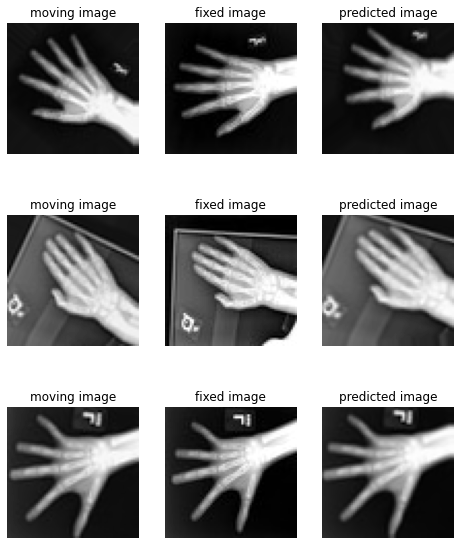

In [14]:
%matplotlib inline
batch_size = 3
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis('off')
plt.show()